In [ ]:
!gdown --id 1XOhzw2SC2fXcebhC5OB_K3d57bwe3BvA

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1XOhzw2SC2fXcebhC5OB_K3d57bwe3BvA
To: /content/images.zip
100% 1.09M/1.09M [00:00<00:00, 49.9MB/s]


In [ ]:
!pip install -q faiss-cpu
!pip install -q git+https://github.com/openai/CLIP.git

  Preparing metadata (setup.py) ... done


In [ ]:
%cd /content/drive/MyDrive/AIC24/data
!bash /content/drive/MyDrive/AIC24/data/get_data.sh
!python /content/drive/MyDrive/AIC24/data/gen_dict_keyframes.py

/content/drive/MyDrive/AIC24/data
Dataset URL: https://www.kaggle.com/datasets/nhnnguynngc/training-aic
License(s): MIT
 96% 172M/179M [00:02<00:00, 67.0MB/s]
100% 179M/179M [00:02<00:00, 77.0MB/s]
Archive:  keyframes/training-aic.zip
  inflating: keyframes/Keyframes_L30/L30_V001/001.jpg  
  inflating: keyframes/Keyframes_L30/L30_V001/002.jpg  
  inflating: keyframes/Keyframes_L30/L30_V001/003.jpg  
  inflating: keyframes/Keyframes_L30/L30_V001/004.jpg  
  inflating: keyframes/Keyframes_L30/L30_V001/005.jpg  
  inflating: keyframes/Keyframes_L30/L30_V001/006.jpg  
  inflating: keyframes/Keyframes_L30/L30_V001/007.jpg  
  inflating: keyframes/Keyframes_L30/L30_V001/008.jpg  
  inflating: keyframes/Keyframes_L30/L30_V001/009.jpg  
  inflating: keyframes/Keyframes_L30/L30_V001/010.jpg  
  inflating: keyframes/Keyframes_L30/L30_V001/011.jpg  
  inflating: keyframes/Keyframes_L30/L30_V001/012.jpg  
  inflating: keyframes/Keyframes_L30/L30_V001/013.jpg  
  inflating: keyframes/Keyframes_L30/

In [ ]:
!pip install -q translate
!pip install -q underthesea==1.3.5a3
!pip install -q underthesea[deep]
!pip install -q pyvi
!pip install -q langdetect
!pip install -q googletrans==3.1.0a0
!pip install -q peft
!pip install bitsandbytes
!pip install transformers
!pip install flash-attn
!pip install -U sentence-transformers

In [ ]:

!pip install -q -U transformers==4.37.2
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 18.7 MB/s eta 0:00:00


In [ ]:
import os
import torch
import clip
from PIL import Image
import faiss
import numpy as np
import json
import matplotlib.pyplot as plt
import math
import googletrans
import translate
import glob
import underthesea
import sys
import time
from tqdm import tqdm
from pyvi import ViUtils, ViTokenizer
from difflib import SequenceMatcher
from langdetect import detect
from pathlib import Path
import re

In [ ]:
%cd /content/drive/MyDrive/AIC24/data

/content/drive/MyDrive/AIC24/data


In [ ]:
ROOT = Path(os.getcwd()).resolve()

# Add ROOT to sys.path
sys.path.append(str(ROOT))

# Determine the working directory
if len(ROOT.parents) > 1:
    WORK_DIR = ROOT.parents[0]
else:
    WORK_DIR = ROOT  # Fallback to ROOT if it doesn't have enough parents

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 34.6MiB/s]


In [ ]:
print("Device :", device)
print("Current Working Directory:", WORK_DIR)

Device : cpu
Current Working Directory: /content


# **Indexing (CLIP)**

In [ ]:
des_path =  f"{WORK_DIR}/data/dicts/npy_clip"
paths = f"{WORK_DIR}/data/keyframes"


for keyframe in tqdm(os.listdir(paths)):
  path_keyframe = os.path.join(paths,keyframe)
  video_paths = sorted(glob.glob(f"{path_keyframe}/*/"))
  video_paths = ['/'.join(i.split('/')[:-1]) for i in video_paths]

  start_time = time.time()
  for vd_path in video_paths:

    re_feats = []
    keyframe_paths = glob.glob(f'{vd_path}/*.jpg')
    keyframe_paths = sorted(keyframe_paths, key=lambda x : x.split('/')[-1].replace('.jpg',''))

    for keyframe_path in keyframe_paths:
      image = preprocess(Image.open(keyframe_path)).unsqueeze(0).to(device)

      with torch.no_grad():
          image_feats = model.encode_image(image)

      image_feats /= image_feats.norm(dim=-1, keepdim=True)
      image_feats = image_feats.detach().cpu().numpy().astype(np.float16).flatten()

      re_feats.append(image_feats)

    name_npy = vd_path.split('/')[-1]

# Construct output file path
    outfile = os.path.join(des_path, f'{name_npy}.npy')

# Ensure the directory exists before saving
    os.makedirs(des_path, exist_ok=True)
    np.save(outfile, re_feats)

100%|██████████| 2/2 [06:45<00:00, 202.57s/it]


In [ ]:
def process_name(name: int):
    return "0"*(6-len(str(name))) + str(name)

def sort_key(file_path):
    file_name = os.path.basename(file_path)
    match = re.match(r'(\D+)(\d+)_(V)(\d+)', file_name)
    if match:
        prefix = match.group(1)
        number = int(match.group(2))
        suffix_number = int(match.group(4))
        return (prefix, number, suffix_number)
    return (file_name, 0, 0)


def write_bin_file_clip(bin_path: str, npy_path: str  ,method='cosine', feature_shape= 512): # Edit 512, 768
  if method in 'L2':
    index = faiss.IndexFlatL2(feature_shape)
  elif method in 'cosine':
    index = faiss.IndexFlatIP(feature_shape)
  else:
    assert f"{method} not supported"

  npy_files = glob.glob(os.path.join(npy_path, "*.npy"))
  npy_files_sorted = sorted(npy_files, key=sort_key)

  for npy_file in npy_files_sorted:
    feats = np.load(npy_file)
    index.add(feats)

  faiss.write_index(index, os.path.join(bin_path, f"faiss_CLIP_{method}.bin"))

  print(f'Saved {os.path.join(bin_path, f"faiss_CLIP_{method}.bin")}')

write_bin_file_clip(bin_path = f"{WORK_DIR}/data/dicts/bin_clip", npy_path = f"{WORK_DIR}/data/dicts/npy_clip")


Saved /content/drive/MyDrive/AIC24/data/dicts/bin_clip/faiss_CLIP_cosine.bin


# **Indexing (OCR, VLM, BLIP)**

In [ ]:
from transformers import DPRContextEncoder, AutoProcessor, DPRContextEncoderTokenizer, BlipModel,TrOCRProcessor, VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer, BitsAndBytesConfig, BlipForConditionalGeneration
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
from sentence_transformers import SentenceTransformer


# tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base', use_fast=False)
# embedding_model = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base').to(device)
embedding_model= SentenceTransformer("nomic-ai/nomic-embed-text-v1", trust_remote_code=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
sentences = ["This is an example sentence", "Each sentence is converted"]
embeddings = embedding_model.encode(sentences)
print(embeddings)

[[ 6.76569194e-02  6.34959713e-02  4.87131476e-02  7.93049783e-02
   3.74480933e-02  2.65277131e-03  3.93749513e-02 -7.09846430e-03
   5.93614057e-02  3.15369777e-02  6.00981042e-02 -5.29052615e-02
   4.06067781e-02 -2.59308387e-02  2.98428647e-02  1.12688600e-03
   7.35148042e-02 -5.03817983e-02 -1.22386612e-01  2.37028562e-02
   2.97265332e-02  4.24768738e-02  2.56337579e-02  1.99516211e-03
  -5.69190793e-02 -2.71598026e-02 -3.29035036e-02  6.60248846e-02
   1.19007230e-01 -4.58791181e-02 -7.26214051e-02 -3.25840116e-02
   5.23413308e-02  4.50553037e-02  8.25298298e-03  3.67024504e-02
  -1.39415674e-02  6.53918684e-02 -2.64271945e-02  2.06370896e-04
  -1.36643145e-02 -3.62810642e-02 -1.95043720e-02 -2.89738011e-02
   3.94270122e-02 -8.84091184e-02  2.62427772e-03  1.36713730e-02
   4.83062901e-02 -3.11566498e-02 -1.17329173e-01 -5.11690713e-02
  -8.85288343e-02 -2.18963325e-02  1.42986095e-02  4.44167666e-02
  -1.34815648e-02  7.43392259e-02  2.66382862e-02 -1.98763069e-02
   1.79191

In [ ]:
paths = f"{WORK_DIR}/data/keyframes"


## Scene Text Detection (easyOCR)

In [ ]:
%cd /content


/content


In [ ]:
!pip install torch
!pip install torchvision
!pip install easyocr
!pip install python-bidi==0.4.2

In [ ]:
!pip install git+https://github.com/JaidedAI/EasyOCR.git

  Cloning https://github.com/JaidedAI/EasyOCR.git to /tmp/pip-req-build-9zk7ft18
  Running command git clone --filter=blob:none --quiet https://github.com/JaidedAI/EasyOCR.git /tmp/pip-req-build-9zk7ft18
  Resolved https://github.com/JaidedAI/EasyOCR.git to commit c999505ef6b43be1c4ee36aa04ad979175178352
  Preparing metadata (setup.py) ... done


In [ ]:
import easyocr
reader = easyocr.Reader(['vi','en']) # this needs to run only once to load the model into memory
result = reader.readtext('/content/026.jpg')


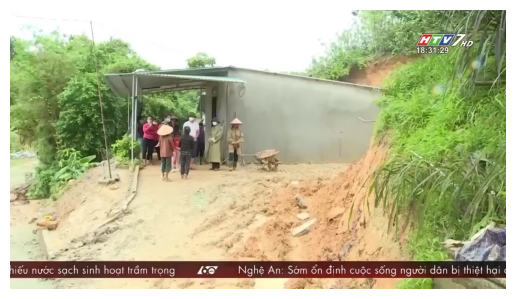

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/026.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
result

[([[1054, 64], [1088, 64], [1088, 90], [1054, 90]], 'IH', 0.05016823759761297),
 ([[1112, 64], [1144, 64], [1144, 92], [1112, 92]],
  'IVI',
  0.44213637000266653),
 ([[1160, 74], [1198, 74], [1198, 98], [1160, 98]], 'HD', 0.33912748522535047),
 ([[1044, 92], [1136, 92], [1136, 116], [1044, 116]],
  '18:31:29',
  0.48255152606717955),
 ([[0, 653], [429, 653], [429, 691], [0, 691]],
  'hiếu nước sạch sinh hoạt trâm trọng',
  0.6644431614645747),
 ([[585, 651], [1273, 651], [1273, 695], [585, 695]],
  'Nghệ An: Sớm ổn dinh cuộc sống người dân bị thiệt hại',
  0.7302298386060019)]

In [ ]:
texts = []


for i in result:
    texts.append(i[1])

merged_text = "\n".join(texts)

print(merged_text)

IH
IVI
HD
18:31:29
hiếu nước sạch sinh hoạt trâm trọng
Nghệ An: Sớm ổn dinh cuộc sống người dân bị thiệt hại


## OCR

### trOCR

In [ ]:

#trOCR
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")




preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Define paths

des_path =  f"{WORK_DIR}/data/dicts/npy_ocr"
os.makedirs(des_path, exist_ok=True)

## VLM

In [ ]:
# Define paths

des_path =  f"{WORK_DIR}/data/dicts/npy_vlm"
os.makedirs(des_path, exist_ok=True)

In [ ]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [ ]:
from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

In [ ]:
image = Image.open("/content/drive/MyDrive/AIC24/data/keyframes/Keyframes_L30/L30_V001/018.jpg")
max_new_tokens = 200
prompt = "USER: <image>\nWhat are the things I should be cautious about when I visit this place?\nASSISTANT:"

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

In [ ]:
print(outputs[0]["generated_text"])

USER:  
What are the things I should be cautious about when I visit this place?
ASSISTANT: When visiting this place, which appears to be a flooded area with a muddy floor, you should be cautious about several things. First, the flooded environment can make the ground slippery, increasing the risk of slips and falls. Second, the water level might be unpredictable, so it's essential to be aware of any sudden changes in water depth. Third, the presence of a person in the image suggests that the area might be inhabited, so be mindful of your surroundings and any potential hazards. Lastly, the muddy floor can make it difficult to move around, so it's crucial to wear appropriate footwear and be prepared for the challenges that come with navigating such an environment.


## BLIP

In [ ]:
model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_mo

In [ ]:
image = Image.open('/content/drive/MyDrive/AIC24/data/keyframes/Keyframes_L30/L30_V001/018.jpg')

inputs = processor(images=image, return_tensors="pt")

image_features = model.get_image_features(**inputs)

inputs = processor(text="a room with a bunch of trash and a bunch of clothes", padding=True, return_tensors="pt")
text_features = model.get_text_features(**inputs)

In [ ]:
image_features.shape

torch.Size([1, 512])

In [ ]:
text_features

tensor([[ 0.2524, -0.1526, -0.1658,  0.4713, -0.1029, -0.4622,  0.3656,  0.1063,
         -0.4133, -0.2181,  0.3688,  0.0486, -0.0740,  0.1178,  0.2919, -0.0424,
          0.3471,  0.1807, -0.0729, -0.2099, -0.0956,  0.1273,  0.2388, -0.2419,
          0.4806,  0.2263, -0.0576,  0.0780, -0.3528, -0.6826,  0.3072,  0.0744,
          0.3294, -0.0938, -0.2074,  0.2141, -0.0011,  0.0014,  0.0218, -0.0678,
          0.2740, -0.0145,  0.2974, -0.2025,  0.1970,  0.0161,  0.1205, -0.0843,
          0.3303, -0.1344, -0.3136,  0.1385, -0.0363, -0.0645, -0.1500,  0.0109,
          0.1140,  0.1326, -0.1640,  0.0917, -0.3118, -0.1711, -0.2944, -0.1542,
         -0.1206, -0.2544,  0.1649, -0.0260,  0.1030, -0.4934,  0.0877,  0.0149,
         -0.0975,  0.5086,  0.2303, -0.1616,  0.1751, -0.2632, -0.2017, -0.1027,
          0.4864,  0.0728, -0.5213,  0.2856,  0.0157,  0.4235,  0.0636,  0.5293,
         -0.2648,  0.0647, -0.4559, -0.4989,  0.0647, -0.0557,  0.0203, -0.3742,
         -0.0223,  0.3143,  

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(image_features.detach().numpy(), text_features.detach().numpy())

array([[-0.04188583]], dtype=float32)

In [ ]:
# Define paths

des_path =  f"{WORK_DIR}/data/dicts/npy_blip"
os.makedirs(des_path, exist_ok=True)

## BLIP2

In [ ]:
from transformers import AutoProcessor, Blip2Model

model = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b")
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt")

image_features = model.get_image_features(**inputs)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")
text_features = model.get_text_features(**inputs)

## function generate text

In [ ]:

# Function to perform OCR on an image and return text
def ocr_image(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

def easyocr_image(image_path):
    texts = []
    result = reader.readtext(image_path)

    for i in result:
      texts.append(i[1])

    merged_text = "\n".join(texts)
    merged_text = Translation(merged_text)
    return merged_text

def vlm_image(image_path):
  image = Image.open(image_path)
  max_new_tokens = 200
  prompt = "USER: <image>\nWhat are the things I should be cautious about when I visit this place?\nASSISTANT:"

  outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
  return outputs[0]["generated_text"]

  return processor.decode(output[0], skip_special_tokens=True)
def blip_image(image_path):
  image = Image.open(image_path)
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  return generated_caption


In [ ]:
text = vlm_image("/content/drive/MyDrive/AIC24/data/keyframes/Keyframes_L30/L30_V001/018.jpg")
print (text )


USER:  
What are the things I should be cautious about when I visit this place?
ASSISTANT: When visiting this place, which appears to be a flooded area with a muddy floor, you should be cautious about several things. First, the flooded environment can make the ground slippery, increasing the risk of slips and falls. Second, the water level might be unpredictable, so it's essential to be aware of any sudden changes in water depth. Third, the presence of a person in the image suggests that the area might be inhabited, so be mindful of your surroundings and any potential hazards. Lastly, the muddy floor can make it difficult to move around, so it's crucial to wear appropriate footwear and be prepared for the challenges that come with navigating such an environment.


In [ ]:
text = blip_image("/content/drive/MyDrive/AIC24/data/keyframes/Keyframes_L30/L30_V001/018.jpg")
print (text )

a room with a bunch of trash and a bunch of clothes


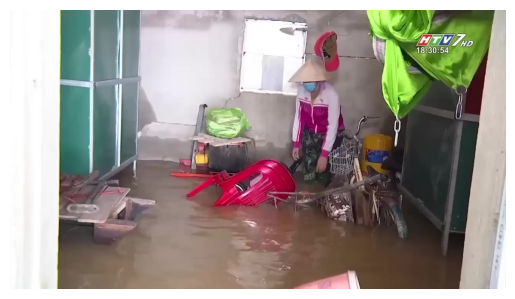

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/drive/MyDrive/AIC24/data/keyframes/Keyframes_L30/L30_V001/018.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
print (des_path)

/content/drive/MyDrive/AIC24/data/dicts/npy_blip


## create file bin

In [ ]:
print(des_path)

In [ ]:
WORK_DIR

In [ ]:

for keyframe in tqdm(os.listdir(paths)):
  path_keyframe = os.path.join(paths,keyframe)
  video_paths = sorted(glob.glob(f"{path_keyframe}/*/"))
  video_paths = ['/'.join(i.split('/')[:-1]) for i in video_paths]

  start_time = time.time()
  for vd_path in video_paths:

    re_feats = []
    keyframe_paths = glob.glob(f'{vd_path}/*.jpg')
    keyframe_paths = sorted(keyframe_paths, key=lambda x : x.split('/')[-1].replace('.jpg',''))

    for keyframe_path in tqdm(keyframe_paths):


      #text = ocr_image(keyframe_path)

      #//////////////////////////////////
      text = vlm_image(keyframe_path)
      #//////////////////////////////////


      # Convert text to embedding vector
      #embedding = embedding_model(**tokenizer(text, return_tensors="pt", padding=True, truncation=True,max_length=512, add_special_tokens = True)).pooler_output.detach().numpy()
      embeddings = embedding_model.encode(text)
      # Append embedding to re_feats list
      re_feats.append(embeddings)

    name_npy = vd_path.split('/')[-1]

    # Construct output file path
    outfile = os.path.join(des_path, f'{name_npy}.npy')

    # Ensure the directory exists before saving
    os.makedirs(des_path, exist_ok=True)
    np.save(outfile, re_feats)

    print(f"Processed {vd_path} in {time.time() - start_time} seconds")


  2%|▏         | 4/235 [00:45<37:51,  9.83s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(

100%|██████████| 235/235 [40:30<00:00, 10.34s/it]


Processed /content/drive/MyDrive/AIC24/data/keyframes/Keyframes_L30/L30_V001 in 2430.0901713371277 seconds



 50%|█████     | 1/2 [1:24:39<1:24:39, 5079.72s/it]

Processed /content/drive/MyDrive/AIC24/data/keyframes/Keyframes_L30/L30_V002 in 5079.7159860134125 seconds



100%|██████████| 241/241 [37:03<00:00,  9.23s/it]


Processed /content/drive/MyDrive/AIC24/data/keyframes/Keyframes_L31/L31_V001 in 2224.4734411239624 seconds



 18%|█▊        | 45/244 [07:04<29:29,  8.89s/it]

In [ ]:
feature_shape = 384


def write_bin_file_ocr(bin_path: str, npy_path: str, method='cosine'):
    if method in 'L2':
      index = faiss.IndexFlatL2(feature_shape)
    elif method in 'cosine':
      index = faiss.IndexFlatIP(feature_shape)
    else:
      assert f"{method} not supported"
    npy_files = glob.glob(os.path.join(npy_path, "*.npy"))
    npy_files_sorted = sorted(npy_files)

    for npy_file in npy_files_sorted:
        feats = np.load(npy_file)
        print(f"Loaded {npy_file}, shape: {feats.shape}")


        # Convert to float32 and reshape to match feature_shape
        feats = feats.astype(np.float32)
        feats = feats.reshape(-1, feats.shape[-1])

        # Resize or trim feats_normalized to match feature_shape if necessary
        if feats.shape[1] != feature_shape:
            feats = feats[:, :feature_shape]

        assert feats.shape[1] == feature_shape, \
            f"Query features dimension {feats.shape[1]} do not match index dimension {feature_shape}"

        # Add to Faiss index
        index.add(feats)

    # Write the Faiss index to disk
    faiss.write_index(index, os.path.join(bin_path, f"faiss_VLM_{method}.bin"))
    print(f'Saved {os.path.join(bin_path, f"faiss_VLM_{method}.bin")}')


# write ocr
write_bin_file_ocr(bin_path=f"{WORK_DIR}/data/dicts/bin_vlm", npy_path=f"{WORK_DIR}/data/dicts/npy_vlm")

# write vlm
#write_bin_file_ocr(bin_path=f"{WORK_DIR}/data/dicts/bin_vlm", npy_path=f"{WORK_DIR}/data/dicts/npy_vlm")

# write blip
#write_bin_file_ocr(bin_path=f"{WORK_DIR}/data/dicts/bin_blip", npy_path=f"{WORK_DIR}/data/dicts/npy_blip")

Loaded /content/drive/MyDrive/AIC24/data/dicts/npy_vlm/L30_V001.npy, shape: (235, 384)
Loaded /content/drive/MyDrive/AIC24/data/dicts/npy_vlm/L30_V002.npy, shape: (273, 384)
Loaded /content/drive/MyDrive/AIC24/data/dicts/npy_vlm/L31_V001.npy, shape: (241, 384)
Loaded /content/drive/MyDrive/AIC24/data/dicts/npy_vlm/L31_V002.npy, shape: (244, 384)
Saved /content/drive/MyDrive/AIC24/data/dicts/bin_vlm/faiss_VLM_cosine.bin


# **Text Preprocessing + translation**

In [ ]:
class Text_Preprocessing():
    def __init__(self, stopwords_path=f"{WORK_DIR}/data/dicts/vietnamese-stopwords-dash.txt"):
        with open(stopwords_path, 'r', encoding='utf-8') as f:  # Open in text mode for easier string handling
            self.stop_words = [line.strip() for line in f.readlines()]

    def find_substring(self, string1, string2):
        match = SequenceMatcher(None, string1, string2, autojunk=False).find_longest_match(0, len(string1), 0, len(string2))
        return string1[match.a:match.a + match.size].strip()

    def remove_stopwords(self, text):
        text = ViTokenizer.tokenize(text)
        filtered_words = [w for w in text.split() if w not in self.stop_words]
        return " ".join(filtered_words)

    def lowercasing(self, text):
        return text.lower()

    def uppercasing(self, text):
        return text.upper()

    def add_accents(self, text):
        return ViUtils.add_accents(text)

    def remove_accents(self, text):
        return ViUtils.remove_accents(text)

    def sentence_segment(self, text):
        return underthesea.sent_tokenize(text)

    def text_norm(self, text):
        return underthesea.text_normalize(text)

    def text_classify(self, text):
        return underthesea.classify(text)

    def sentiment_analysis(self, text):
        return underthesea.sentiment(text)

    def __call__(self, text):
        # Apply preprocessing steps
        text = self.lowercasing(text)
        text = self.remove_stopwords(text)
        # Uncomment and adjust as needed
        # text = self.remove_accents(text)
        # text = self.add_accents(text)
        text = self.text_norm(text)
        return text  # Return the processed text

class Translation():
    def __init__(self, from_lang='vi', to_lang='en', mode='google'):
        # The class Translation is a wrapper for the two translation libraries, googletrans and translate.
        self.__mode = mode
        self.__from_lang = from_lang
        self.__to_lang = to_lang
        self.text_processing = Text_Preprocessing()
        if mode in 'googletrans':
            self.translator = googletrans.Translator()
        elif mode in 'translate':
            self.translator = translate.Translator(from_lang=from_lang,to_lang=to_lang)

    def preprocessing(self, text):

        return self.text_processing(text) #text.lower()

    def __call__(self, text):

        text = self.preprocessing(text)
        return self.translator.translate(text) if self.__mode in 'translate' \
                else self.translator.translate(text, dest=self.__to_lang).text



# **Faiss**

In [ ]:
import clip
from sentence_transformers import SentenceTransformer

class MyFaiss:
  def __init__(self, bin_file: str, dict_json: str,device , mode):
    self.index = self.load_bin_file(bin_file)
    self.translate = Translation()
    self.dict_json = self._read_json(dict_json)
    self.mode = mode
    self.device = device
    self.d = self.index.d
    if mode == "clip":
      self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
    else:
      self.q_encoder = SentenceTransformer("nomic-ai/nomic-embed-text-v1", trust_remote_code=True)


  def load_bin_file(self, bin_file: str):
    return faiss.read_index(bin_file)

  def _read_json(self, file_json):
    with open(file_json, "r") as file:
      data = json.load(file)
    return data

  def image_search(self, id_query, k, bin_file):

    query_feats = self.index.reconstruct(id_query).reshape(1,-1)

    scores, idx_image = self.index.search(query_feats, k=k)
    idx_image = idx_image.flatten()

    infos_query = list(map(self.id2img_fps.get, list(idx_image)))
    image_paths = [info for info in infos_query]


    return scores, idx_image, infos_query, image_paths
  def show_images(self, image_paths):
    fig = plt.figure(figsize=(15, 10))
    columns = int(math.sqrt(len(image_paths)))
    rows = int(np.ceil(len(image_paths)/columns))

    for i in range(1, columns*rows +1):
      img = plt.imread(image_paths[i - 1])
      ax = fig.add_subplot(rows, columns, i)
      ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

      plt.imshow(img)
      plt.axis("off")

    plt.show()

  def text_search(self, text, k):
    if detect(text) == 'vi' :
        text = self.translate(text)
    print("Text translation: ", text)

    if self.mode == "clip":
        with torch.no_grad():
            text = clip.tokenize([text]).to(self.device)
            text_features = self.model.encode_text(text).cpu().numpy().astype(np.float32)
    else:
        with torch.no_grad():
            text_features = self.q_encoder.encode(text)

    print("text_features.shape:", text_features.shape)
    text_features = text_features.reshape(1, -1)

  # Resize or pad text_features to match the dimensionality of self.d
    if text_features.shape[1] != self.d:
      if text_features.shape[1] < self.d:
          text_features = np.pad(text_features, ((0, 0), (0, self.d - text_features.shape[1])), 'constant')
      else:
          text_features = text_features[:, :self.d]
          pass

    assert text_features.shape == (1, self.d), f"Query features shape {text_features.shape} do not match expected shape (1, {self.d})"

    # Perform the search using Faiss
    scores, idx_image = self.index.search(text_features, k=k)

    # Map indices to result strings
    result_strings = list(map(lambda idx: self.dict_json[idx] if 0 <= idx < len(self.dict_json) else None, idx_image[-1]))
    return result_strings


Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokeniz

Text translation:  nước dâng cao, lũ lụt, sạc lỡ đất
text_features.shape: (768,)


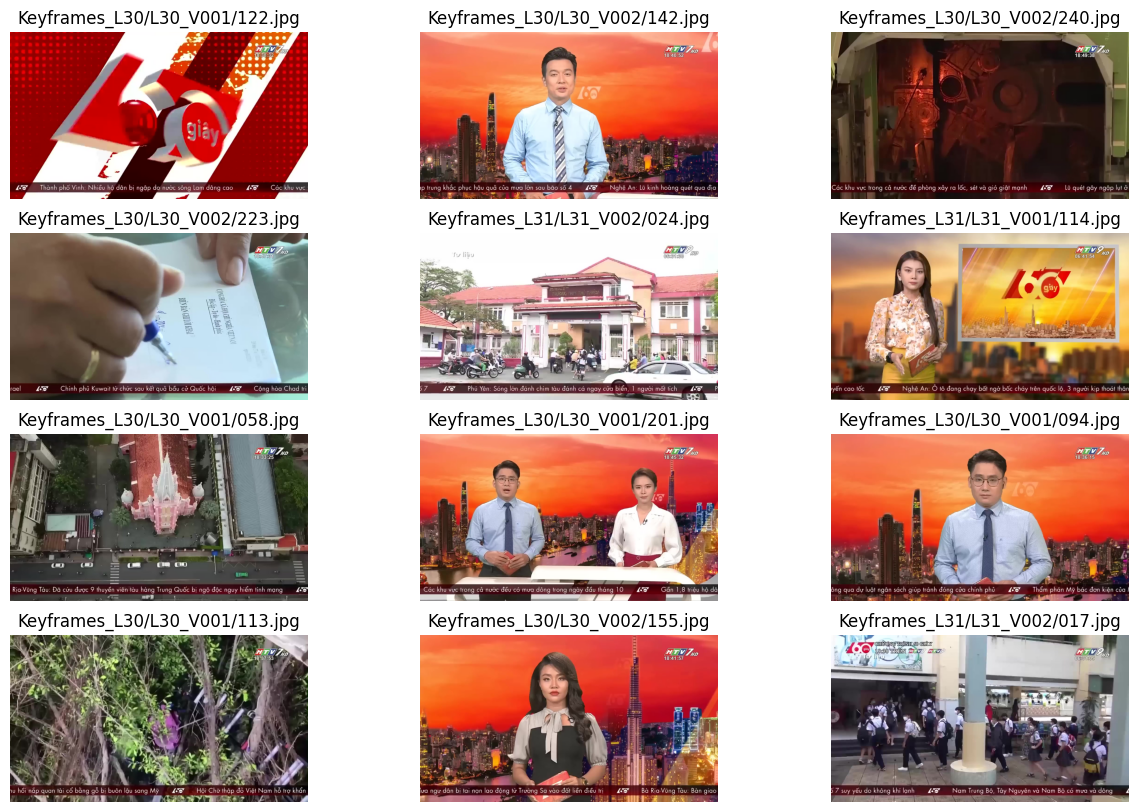

In [ ]:
def main():

  ##### TESTING #####
  bin_file=f"{WORK_DIR}/data/dicts/bin_ocr/faiss_OCR_cosine.bin"
  json_path = f"{WORK_DIR}/data/dicts/keyframes_id_search.json"

  cosine_faiss = MyFaiss(bin_file, json_path, device, "ocr")


  ##### TEXT SEARCH #####
  text = f"nước dâng cao, lũ lụt, sạc lỡ đất"


  image_paths = cosine_faiss.text_search(text, k=12)
  # cosine_faiss.write_csv(infos_query, des_path_submit='./')
  base_path = f"{WORK_DIR}/data/"

  # Tạo đường dẫn tuyệt đối cho từng hình ảnh
  img_paths = [os.path.join(base_path, image_path) for image_path in image_paths]
  cosine_faiss.show_images(img_paths)

if __name__ == "__main__":
    main()

In [ ]:
text = f"nước dâng cao, lũ lụt, sạc lỡ đất "
text_features = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').encode(text)

In [ ]:
text_features

array([-1.04848795e-01,  3.73925045e-02, -1.88762750e-02,  4.36859857e-03,
       -4.84944182e-03,  1.11107994e-03,  6.56673908e-02,  1.19634658e-01,
        1.26868561e-01, -1.02631403e-02,  7.76833594e-02, -1.17886111e-01,
       -5.55618070e-02, -8.53972882e-03,  1.68316271e-02, -2.89975759e-03,
       -7.76887238e-02,  7.18657747e-02, -5.89863695e-02, -8.96737352e-02,
       -3.01245376e-02, -8.50056484e-03, -1.33874477e-03, -5.13726473e-02,
       -4.55858819e-02, -7.42981955e-02,  3.52140479e-02,  6.01106249e-02,
        1.94476061e-02, -9.95741785e-02,  6.25796467e-02,  9.59262922e-02,
        4.75527197e-02,  2.53644325e-02,  1.63028836e-02,  6.93800813e-03,
       -3.20915766e-02, -1.55783311e-01, -1.18047660e-02,  1.58681311e-02,
        2.66237464e-02,  5.71750030e-02,  9.77232773e-03, -9.19133276e-02,
        7.18050376e-02,  8.23633969e-02, -4.51010615e-02, -3.66109423e-02,
       -5.04721701e-02, -7.04969978e-03, -2.22225506e-02, -3.46986465e-02,
       -6.75425380e-02,  

# Ranking

# Re-Ranking

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/AIC24/model/model_sparse_f30k.pth.tar', map_location=torch.device('cpu'))


In [ ]:
checkpoint

{'opt': Namespace(grad_clip=2.0, vocab_size=8481, word_dim=300, embed_size=1024, data_path='/media/ubuntu/data/chunxiao', val_step=15000, num_layers=1, out_dim=1, num_epochs=30, workers=10, lr_update=15, log_step=100, max_violation=True, no_imgnorm=False, data_name='f30k_precomp', vocab_path='/media/ubuntu/data/chunxiao/vocab', learning_rate=0.0002, batch_size=64, bi_gru=True, logger_name='runs/log', no_txtnorm=False, is_sparse=True, lambda_softmax=20.0, resume='', hid_dim=32, img_dim=2048, num_block=16, feat_dim=16, margin=0.2, model_name='./model'),
 'Eiters': 61182,
 'epoch': 27,
 'best_rsum': 477.65999999999997,
 'model': [OrderedDict([('fc.weight',
                tensor([[-0.0219,  0.0461,  0.0873,  ...,  0.0502,  0.0920, -0.0486],
                        [ 0.1211, -0.0075, -0.0366,  ...,  0.0687, -0.0121,  0.0856],
                        [ 0.0574, -0.0019, -0.0130,  ...,  0.0176, -0.0151,  0.0420],
                        ...,
                        [-0.0815, -0.0461, -0.0132,